In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


* **Getting the train and test dataset**

In [4]:
# Define a classe de transformação
class Transform:
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define a classe SeismicDataset para carregar dados binários
class SeismicDataset:
    def __init__(self, elastic_folder, acoustic_folder, shape=(256, 256, 1)):
        self.elastic_files = sorted([os.path.join(elastic_folder, f) for f in os.listdir(elastic_folder) if f.endswith('.bin')])
        self.acoustic_files = sorted([os.path.join(acoustic_folder, f) for f in os.listdir(acoustic_folder) if f.endswith('.bin')])
        self.transformer = Transform()

        # Define o tamanho dos patches com base no parâmetro `shape`
        self.patch_shape = shape

        # Verifica se o número de patches é o mesmo em ambas as pastas
        assert len(self.elastic_files) == len(self.acoustic_files), "Número de patches deve ser igual em ambas as pastas."

    def __len__(self):
        return len(self.elastic_files)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        # Carrega os patches binários para elastic e acoustic
        elastic_patch = np.fromfile(self.elastic_files[idx], dtype='float32').reshape(self.patch_shape)
        acoustic_patch = np.fromfile(self.acoustic_files[idx], dtype='float32').reshape(self.patch_shape)
        
        # Transforma para tensor
        elastic_patch = self.transformer(elastic_patch)
        acoustic_patch = self.transformer(acoustic_patch)

        return acoustic_patch, elastic_patch


# Define as pastas de treino e teste
train_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\elastic_vx'
train_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\acoustic'
test_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\elastic_vx'
test_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\acoustic'

# Cria o dataset e DataLoader para treino e teste
train_ds = SeismicDataset(train_elastic_path, train_acoustic_path, shape=(256, 256, 1))
test_ds = SeismicDataset(test_elastic_path, test_acoustic_path, shape=(768, 361, 1))

# Parâmetros do DataLoader
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 1

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=False, drop_last=False)

print("DataLoaders de treino e teste criados com sucesso!")

DataLoaders de treino e teste criados com sucesso!


In [5]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 61


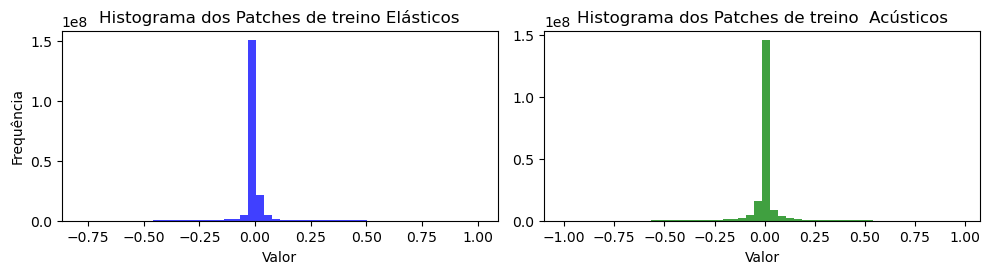

In [6]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

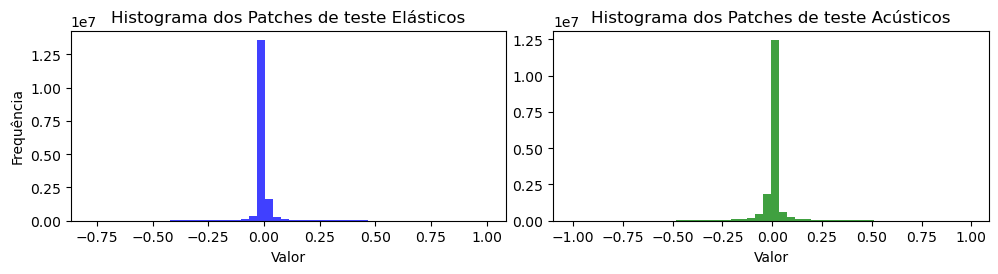

In [7]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

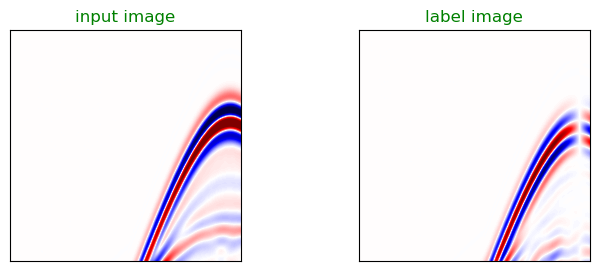

In [8]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("label image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

* **Define the generator and discriminator**

In [10]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, 4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, 4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

* **Define the Loss**

In [13]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() # Perda quadrática

* **Inicializando os modelos na GPU**

In [15]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [16]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [17]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        real_input_img = real_input[0].squeeze().cpu()
        real_target_img = real_target[0].squeeze().cpu()
        fake_image_img = fake_image[0].squeeze().cpu()

        perc = 99
        vmax = np.percentile(np.abs(real_input_img), perc)
        vmin = -vmax

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[0].set_title('Real Input', c="g")
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_title('Real Target', c="g")
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[2].set_title('Generated Image', c="g")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


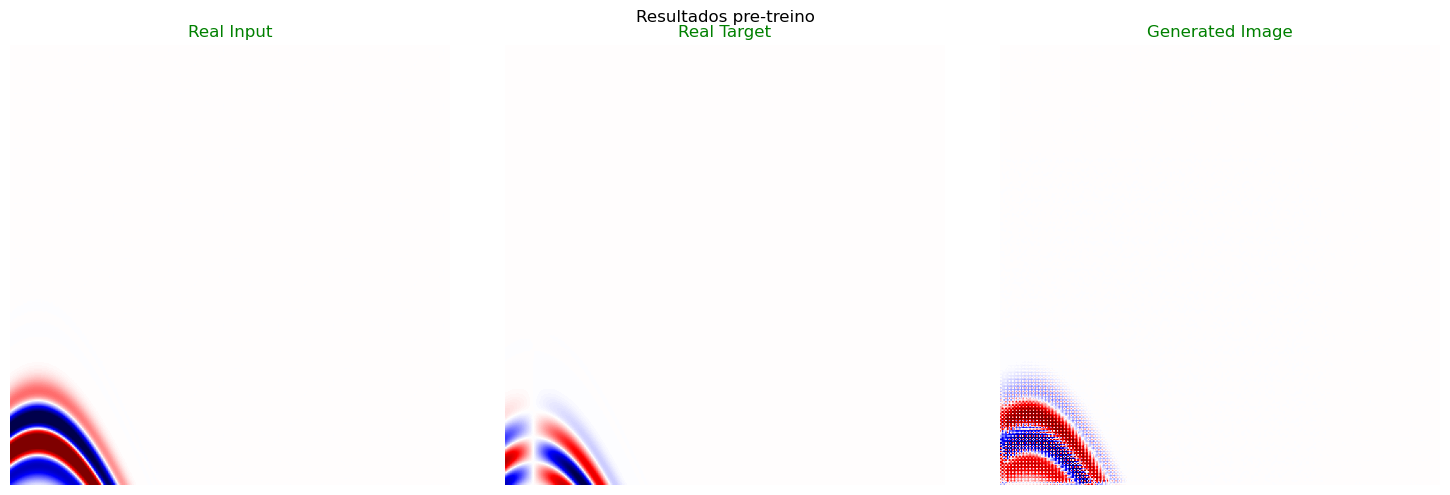

In [18]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [19]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [20]:
n_epoches = 150
decay_epoch = 40 # Reference paper
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_func)

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 1000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        it = i+1
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) 
        # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com base na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()

        if it % 4 == 0:
            
            """Train Discriminator """
            optimizer_D.zero_grad()
            
            loss_real = criterion_GAN(D(input, target), real_label)
            loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
            loss_D = (loss_real + loss_fake) * 0.5
            
            loss_D.backward()
            optimizer_D.step()

    lr_scheduler_G.step()
    lr_scheduler_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.87it/s]


[Epoch 1/150]
[G loss: 11.041935920715332 | GAN: 0.8694512248039246 L1: 0.010172484442591667]
[D loss: 0.4144819974899292]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 2/150]
[G loss: 17.509479522705078 | GAN: 1.16898775100708 L1: 0.01634049229323864]
[D loss: 0.5311119556427002]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.95it/s]


[Epoch 3/150]
[G loss: 13.086162567138672 | GAN: 2.0789246559143066 L1: 0.011007238179445267]
[D loss: 0.5060890913009644]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 4/150]
[G loss: 10.437625885009766 | GAN: 0.843878984451294 L1: 0.009593747556209564]
[D loss: 0.6996245384216309]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.15it/s]


[Epoch 5/150]
[G loss: 6.4085283279418945 | GAN: 1.209610939025879 L1: 0.005198917351663113]
[D loss: 0.7093396186828613]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.11it/s]


[Epoch 6/150]
[G loss: 8.67876148223877 | GAN: 1.0210285186767578 L1: 0.0076577328145504]
[D loss: 0.6038541197776794]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.02it/s]


[Epoch 7/150]
[G loss: 5.348968982696533 | GAN: 1.1475244760513306 L1: 0.004201444797217846]
[D loss: 0.7001487016677856]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 8/150]
[G loss: 5.02898645401001 | GAN: 0.9140203595161438 L1: 0.004114965908229351]
[D loss: 0.5747484564781189]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.10it/s]


[Epoch 9/150]
[G loss: 2.3768744468688965 | GAN: 0.6608995199203491 L1: 0.0017159749986603856]
[D loss: 0.6413404941558838]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.09it/s]


[Epoch 10/150]
[G loss: 7.577697277069092 | GAN: 0.45984986424446106 L1: 0.007117847446352243]
[D loss: 0.5959417819976807]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 11/150]
[G loss: 3.5317533016204834 | GAN: 0.7125503420829773 L1: 0.0028192028403282166]
[D loss: 0.6953768134117126]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.13it/s]


[Epoch 12/150]
[G loss: 5.096126079559326 | GAN: 0.9613050818443298 L1: 0.004134820774197578]
[D loss: 0.641342043876648]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.71it/s]


[Epoch 13/150]
[G loss: 3.4256677627563477 | GAN: 0.5285962820053101 L1: 0.0028970714192837477]
[D loss: 0.692101776599884]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.72it/s]


[Epoch 14/150]
[G loss: 8.254701614379883 | GAN: 0.7451291680335999 L1: 0.007509572431445122]
[D loss: 0.690406084060669]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.92it/s]


[Epoch 15/150]
[G loss: 2.2441365718841553 | GAN: 0.860752522945404 L1: 0.0013833841076120734]
[D loss: 0.6457758545875549]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.86it/s]


[Epoch 16/150]
[G loss: 3.7136216163635254 | GAN: 0.6791700720787048 L1: 0.003034451510757208]
[D loss: 0.6708660125732422]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 17/150]
[G loss: 4.279458045959473 | GAN: 0.685276985168457 L1: 0.0035941810347139835]
[D loss: 0.6584354639053345]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.14it/s]


[Epoch 18/150]
[G loss: 5.92915153503418 | GAN: 0.6728289723396301 L1: 0.0052563222125172615]
[D loss: 0.6720041632652283]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.99it/s]


[Epoch 19/150]
[G loss: 3.401963233947754 | GAN: 0.5627857446670532 L1: 0.0028391776140779257]
[D loss: 0.6584063768386841]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.79it/s]


[Epoch 20/150]
[G loss: 4.596070766448975 | GAN: 0.8161808252334595 L1: 0.003779890015721321]
[D loss: 0.7333293557167053]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.95it/s]


[Epoch 21/150]
[G loss: 5.373883247375488 | GAN: 0.6748666763305664 L1: 0.004699016455560923]
[D loss: 0.6946436166763306]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.10it/s]


[Epoch 22/150]
[G loss: 4.027955055236816 | GAN: 0.9229122996330261 L1: 0.0031050429679453373]
[D loss: 0.6753315925598145]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.91it/s]


[Epoch 23/150]
[G loss: 2.907498836517334 | GAN: 0.7333543300628662 L1: 0.002174144610762596]
[D loss: 0.6857604384422302]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.88it/s]


[Epoch 24/150]
[G loss: 4.579787731170654 | GAN: 0.7979294061660767 L1: 0.003781858365982771]
[D loss: 0.6561292409896851]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.19it/s]


[Epoch 25/150]
[G loss: 4.977108001708984 | GAN: 1.396044135093689 L1: 0.003581063821911812]
[D loss: 0.211343914270401]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.92it/s]


[Epoch 26/150]
[G loss: 7.961768627166748 | GAN: 3.0017142295837402 L1: 0.0049600545316934586]
[D loss: 0.3573974668979645]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.15it/s]


[Epoch 27/150]
[G loss: 1.461948037147522 | GAN: 0.6759810447692871 L1: 0.0007859669858589768]
[D loss: 0.6732956171035767]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 28/150]
[G loss: 2.7080941200256348 | GAN: 0.8547603487968445 L1: 0.0018533336697146297]
[D loss: 0.6690241098403931]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 29/150]
[G loss: 4.5195841789245605 | GAN: 1.0169620513916016 L1: 0.0035026222467422485]
[D loss: 0.6760061979293823]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.63it/s]


[Epoch 30/150]
[G loss: 2.3026766777038574 | GAN: 0.6331983804702759 L1: 0.0016694782534614205]
[D loss: 0.6955215334892273]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.75it/s]


[Epoch 31/150]
[G loss: 3.2879345417022705 | GAN: 0.6254079937934875 L1: 0.0026625266764312983]
[D loss: 0.7149705290794373]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 32/150]
[G loss: 6.597407341003418 | GAN: 4.102779388427734 L1: 0.00249462784267962]
[D loss: 0.45606109499931335]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.75it/s]


[Epoch 33/150]
[G loss: 5.3298139572143555 | GAN: 0.6617032885551453 L1: 0.004668110981583595]
[D loss: 0.4423821270465851]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.63it/s]


[Epoch 34/150]
[G loss: 5.755676746368408 | GAN: 1.192543387413025 L1: 0.004563133232295513]
[D loss: 0.6728740930557251]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.03it/s]


[Epoch 35/150]
[G loss: 8.864967346191406 | GAN: 5.926124095916748 L1: 0.0029388433322310448]
[D loss: 0.1270369589328766]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.00it/s]


[Epoch 36/150]
[G loss: 7.619251728057861 | GAN: 5.6471757888793945 L1: 0.0019720757845789194]
[D loss: 0.12831974029541016]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.18it/s]


[Epoch 37/150]
[G loss: 2.921623706817627 | GAN: 0.692844808101654 L1: 0.002228778786957264]
[D loss: 0.7085304260253906]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.94it/s]


[Epoch 38/150]
[G loss: 3.6054930686950684 | GAN: 0.6636121273040771 L1: 0.002941880840808153]
[D loss: 0.6789307594299316]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.86it/s]


[Epoch 39/150]
[G loss: 11.234719276428223 | GAN: 5.786073207855225 L1: 0.0054486459121108055]
[D loss: 0.023274218663573265]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.84it/s]


[Epoch 40/150]
[G loss: 2.0898869037628174 | GAN: 0.797243058681488 L1: 0.0012926438357681036]
[D loss: 0.7242981195449829]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 41/150]
[G loss: 4.144394874572754 | GAN: 0.7009415626525879 L1: 0.0034434529952704906]
[D loss: 0.6957509517669678]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 42/150]
[G loss: 4.999427795410156 | GAN: 3.6198437213897705 L1: 0.0013795841950923204]
[D loss: 0.06526204943656921]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.91it/s]


[Epoch 43/150]
[G loss: 9.444631576538086 | GAN: 6.4676899909973145 L1: 0.0029769418761134148]
[D loss: 0.019869104027748108]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.09it/s]


[Epoch 44/150]
[G loss: 4.632176876068115 | GAN: 1.288085699081421 L1: 0.00334409112110734]
[D loss: 0.2757134735584259]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 45/150]
[G loss: 10.231071472167969 | GAN: 6.557822227478027 L1: 0.0036732489243149757]
[D loss: 0.057485517114400864]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.93it/s]


[Epoch 46/150]
[G loss: 8.55016040802002 | GAN: 5.756069660186768 L1: 0.002794090658426285]
[D loss: 0.06984110176563263]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.78it/s]


[Epoch 47/150]
[G loss: 10.291930198669434 | GAN: 6.803608417510986 L1: 0.003488321788609028]
[D loss: 0.003218888072296977]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.57it/s]


[Epoch 48/150]
[G loss: 10.328017234802246 | GAN: 6.731297969818115 L1: 0.0035967191215604544]
[D loss: 0.007459104526787996]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.93it/s]


[Epoch 49/150]
[G loss: 2.9074230194091797 | GAN: 0.7492746710777283 L1: 0.0021581482142210007]
[D loss: 0.6779993772506714]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.78it/s]


[Epoch 50/150]
[G loss: 1.8761502504348755 | GAN: 0.179288849234581 L1: 0.0016968613490462303]
[D loss: 1.091507077217102]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.66it/s]


[Epoch 51/150]
[G loss: 3.460512638092041 | GAN: 1.0782586336135864 L1: 0.0023822542279958725]
[D loss: 0.7054910659790039]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 52/150]
[G loss: 10.666078567504883 | GAN: 8.083913803100586 L1: 0.0025821649469435215]
[D loss: 0.00982019305229187]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.93it/s]


[Epoch 53/150]
[G loss: 12.443007469177246 | GAN: 8.353096961975098 L1: 0.004089910537004471]
[D loss: 0.008571918122470379]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.98it/s]


[Epoch 54/150]
[G loss: 8.971027374267578 | GAN: 5.601907730102539 L1: 0.003369120182469487]
[D loss: 0.05247688665986061]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.78it/s]


[Epoch 55/150]
[G loss: 6.277950286865234 | GAN: 4.783242225646973 L1: 0.0014947077725082636]
[D loss: 0.037594765424728394]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.65it/s]


[Epoch 56/150]
[G loss: 11.225349426269531 | GAN: 8.338454246520996 L1: 0.002886895090341568]
[D loss: 0.002089740475639701]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.81it/s]


[Epoch 57/150]
[G loss: 5.385318756103516 | GAN: 4.32550048828125 L1: 0.0010598180815577507]
[D loss: 0.027662985026836395]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 58/150]
[G loss: 12.521127700805664 | GAN: 8.363885879516602 L1: 0.004157241899520159]
[D loss: 0.004142042715102434]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.40it/s]


[Epoch 59/150]
[G loss: 11.724871635437012 | GAN: 7.357351303100586 L1: 0.004367520101368427]
[D loss: 0.4734111726284027]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 60/150]
[G loss: 8.447248458862305 | GAN: 6.13385009765625 L1: 0.0023133980575948954]
[D loss: 0.168769970536232]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.47it/s]


[Epoch 61/150]
[G loss: 3.6057095527648926 | GAN: 0.6052156686782837 L1: 0.0030004940927028656]
[D loss: 0.7406577467918396]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 62/150]
[G loss: 2.285334587097168 | GAN: 0.6978539824485779 L1: 0.0015874806558713317]
[D loss: 0.6970346570014954]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.47it/s]


[Epoch 63/150]
[G loss: 2.668428659439087 | GAN: 0.7008249163627625 L1: 0.0019676038064062595]
[D loss: 0.6980200409889221]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.11it/s]


[Epoch 64/150]
[G loss: 2.909670829772949 | GAN: 0.7203795909881592 L1: 0.002189291175454855]
[D loss: 0.6781511306762695]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.31it/s]


[Epoch 65/150]
[G loss: 7.520092964172363 | GAN: 5.7460408210754395 L1: 0.0017740523908287287]
[D loss: 0.024878399446606636]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.19it/s]


[Epoch 66/150]
[G loss: 5.674037933349609 | GAN: 4.118394374847412 L1: 0.001555643742904067]
[D loss: 0.0022166732233017683]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.11it/s]


[Epoch 67/150]
[G loss: 9.513883590698242 | GAN: 6.358896255493164 L1: 0.0031549870036542416]
[D loss: 0.003583052661269903]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.99it/s]


[Epoch 68/150]
[G loss: 3.2898097038269043 | GAN: 2.8869845867156982 L1: 0.0004028250405099243]
[D loss: 0.0018165067303925753]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.20it/s]


[Epoch 69/150]
[G loss: 2.909201145172119 | GAN: 0.9122560024261475 L1: 0.00199694512411952]
[D loss: 0.24187175929546356]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 70/150]
[G loss: 6.185969352722168 | GAN: 5.145028114318848 L1: 0.0010409409878775477]
[D loss: 0.00732182152569294]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 71/150]
[G loss: 10.88105583190918 | GAN: 8.621750831604004 L1: 0.0022593047469854355]
[D loss: 0.0012866829056292772]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.08it/s]


[Epoch 72/150]
[G loss: 8.836749076843262 | GAN: 6.670842170715332 L1: 0.0021659070625901222]
[D loss: 0.004633515141904354]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.31it/s]


[Epoch 73/150]
[G loss: 3.457451105117798 | GAN: 2.5374746322631836 L1: 0.00091997638810426]
[D loss: 0.0355636402964592]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.19it/s]


[Epoch 74/150]
[G loss: 6.647538185119629 | GAN: 5.369423866271973 L1: 0.0012781141558662057]
[D loss: 0.3035631775856018]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.79it/s]


[Epoch 75/150]
[G loss: 4.669032573699951 | GAN: 2.7195496559143066 L1: 0.0019494830630719662]
[D loss: 0.002676180563867092]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.15it/s]


[Epoch 76/150]
[G loss: 8.755462646484375 | GAN: 4.8062567710876465 L1: 0.003949206322431564]
[D loss: 0.32003235816955566]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.82it/s]


[Epoch 77/150]
[G loss: 2.8329367637634277 | GAN: 0.7816239595413208 L1: 0.002051312942057848]
[D loss: 0.6755492687225342]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.94it/s]


[Epoch 78/150]
[G loss: 4.728755950927734 | GAN: 2.65962553024292 L1: 0.0020691300742328167]
[D loss: 0.39205634593963623]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 79/150]
[G loss: 7.668789863586426 | GAN: 5.294142246246338 L1: 0.002374647418037057]
[D loss: 0.00367233669385314]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.35it/s]


[Epoch 80/150]
[G loss: 14.435009002685547 | GAN: 10.39186954498291 L1: 0.004043139982968569]
[D loss: 0.001157908234745264]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.02it/s]


[Epoch 81/150]
[G loss: 14.057022094726562 | GAN: 10.288887977600098 L1: 0.0037681343965232372]
[D loss: 0.0013402499025687575]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.84it/s]


[Epoch 82/150]
[G loss: 13.801464080810547 | GAN: 10.684318542480469 L1: 0.0031171455048024654]
[D loss: 0.000596135389059782]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.80it/s]


[Epoch 83/150]
[G loss: 2.4587159156799316 | GAN: 0.7536753416061401 L1: 0.0017050406895577908]
[D loss: 0.7255821228027344]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.97it/s]


[Epoch 84/150]
[G loss: 6.999083518981934 | GAN: 4.912073612213135 L1: 0.002087010070681572]
[D loss: 0.02816000208258629]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.90it/s]


[Epoch 85/150]
[G loss: 11.180915832519531 | GAN: 8.708361625671387 L1: 0.0024725538678467274]
[D loss: 0.008723199367523193]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.97it/s]


[Epoch 86/150]
[G loss: 11.802112579345703 | GAN: 9.586195945739746 L1: 0.0022159165237098932]
[D loss: 0.004340427927672863]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.99it/s]


[Epoch 87/150]
[G loss: 1.8004770278930664 | GAN: 0.8640390634536743 L1: 0.0009364379802718759]
[D loss: 0.7123473882675171]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.98it/s]


[Epoch 88/150]
[G loss: 2.6518611907958984 | GAN: 0.6902190446853638 L1: 0.001961642177775502]
[D loss: 0.6761621236801147]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.95it/s]


[Epoch 89/150]
[G loss: 3.08799147605896 | GAN: 0.8172082901000977 L1: 0.0022707832977175713]
[D loss: 0.6417363286018372]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.97it/s]


[Epoch 90/150]
[G loss: 6.58062219619751 | GAN: 3.70231556892395 L1: 0.0028783066663891077]
[D loss: 0.42569640278816223]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.89it/s]


[Epoch 91/150]
[G loss: 7.287720203399658 | GAN: 5.890151023864746 L1: 0.0013975691981613636]
[D loss: 0.02333381585776806]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 92/150]
[G loss: 9.190069198608398 | GAN: 7.114326477050781 L1: 0.002075742930173874]
[D loss: 0.0026467242278158665]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.97it/s]


[Epoch 93/150]
[G loss: 10.117876052856445 | GAN: 8.00617790222168 L1: 0.002111697569489479]
[D loss: 0.0008926776936277747]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.96it/s]


[Epoch 94/150]
[G loss: 10.976947784423828 | GAN: 8.928173065185547 L1: 0.0020487746223807335]
[D loss: 0.015291650779545307]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.96it/s]


[Epoch 95/150]
[G loss: 4.092148780822754 | GAN: 2.5994961261749268 L1: 0.0014926528092473745]
[D loss: 0.020077208057045937]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 96/150]
[G loss: 10.106146812438965 | GAN: 8.402006149291992 L1: 0.001704140566289425]
[D loss: 0.0009890234796330333]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.96it/s]


[Epoch 97/150]
[G loss: 7.484550476074219 | GAN: 6.924381732940674 L1: 0.0005601686425507069]
[D loss: 0.0009802456479519606]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.97it/s]


[Epoch 98/150]
[G loss: 10.1506986618042 | GAN: 8.612905502319336 L1: 0.0015377935487776995]
[D loss: 0.0013254606164991856]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.97it/s]


[Epoch 99/150]
[G loss: 3.400341749191284 | GAN: 2.310380697250366 L1: 0.0010899610351771116]
[D loss: 0.009219346567988396]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 100/150]
[G loss: 7.914240837097168 | GAN: 5.700992107391357 L1: 0.0022132485173642635]
[D loss: 0.21598173677921295]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.08it/s]


[Epoch 101/150]
[G loss: 8.454383850097656 | GAN: 6.883670806884766 L1: 0.0015707132406532764]
[D loss: 0.008452586829662323]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.00it/s]


[Epoch 102/150]
[G loss: 7.341578483581543 | GAN: 6.253410339355469 L1: 0.0010881678899750113]
[D loss: 0.005326495505869389]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.94it/s]


[Epoch 103/150]
[G loss: 7.797327995300293 | GAN: 5.168137550354004 L1: 0.002629190217703581]
[D loss: 0.004213160835206509]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.22it/s]


[Epoch 104/150]
[G loss: 9.815147399902344 | GAN: 8.448624610900879 L1: 0.0013665230944752693]
[D loss: 0.0008902502595447004]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.85it/s]


[Epoch 105/150]
[G loss: 7.153710842132568 | GAN: 6.324930667877197 L1: 0.000828780117444694]
[D loss: 0.0007965303375385702]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.68it/s]


[Epoch 106/150]
[G loss: 9.861969947814941 | GAN: 8.49550724029541 L1: 0.0013664629077538848]
[D loss: 0.0007740632863715291]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.80it/s]


[Epoch 107/150]
[G loss: 2.575350284576416 | GAN: 1.7035986185073853 L1: 0.0008717516320757568]
[D loss: 0.04235235974192619]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.54it/s]


[Epoch 108/150]
[G loss: 12.236888885498047 | GAN: 10.050387382507324 L1: 0.002186500933021307]
[D loss: 0.015475898049771786]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.71it/s]


[Epoch 109/150]
[G loss: 7.5487823486328125 | GAN: 5.221142768859863 L1: 0.002327639376744628]
[D loss: 0.0008686308865435421]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.79it/s]


[Epoch 110/150]
[G loss: 9.573701858520508 | GAN: 6.8777875900268555 L1: 0.0026959143579006195]
[D loss: 0.011045830324292183]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.93it/s]


[Epoch 111/150]
[G loss: 4.021152019500732 | GAN: 1.7210549116134644 L1: 0.0023000971414148808]
[D loss: 0.01217660866677761]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.96it/s]


[Epoch 112/150]
[G loss: 8.79723072052002 | GAN: 8.071695327758789 L1: 0.0007255352102220058]
[D loss: 0.008580139838159084]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 113/150]
[G loss: 12.18466854095459 | GAN: 9.888626098632812 L1: 0.0022960426285862923]
[D loss: 0.0012808473547920585]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.03it/s]


[Epoch 114/150]
[G loss: 13.873391151428223 | GAN: 11.969966888427734 L1: 0.001903424272313714]
[D loss: 0.0022840755991637707]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.01it/s]


[Epoch 115/150]
[G loss: 2.2192249298095703 | GAN: 1.736891269683838 L1: 0.0004823336494155228]
[D loss: 0.10575398057699203]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.02it/s]


[Epoch 116/150]
[G loss: 9.893712997436523 | GAN: 8.789549827575684 L1: 0.0011041628895327449]
[D loss: 0.0031850412487983704]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.98it/s]


[Epoch 117/150]
[G loss: 6.174262046813965 | GAN: 4.406429290771484 L1: 0.0017678325530141592]
[D loss: 0.0021692418958991766]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.99it/s]


[Epoch 118/150]
[G loss: 12.88007640838623 | GAN: 11.166452407836914 L1: 0.0017136241076514125]
[D loss: 0.00039361679228022695]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.99it/s]


[Epoch 119/150]
[G loss: 12.9203519821167 | GAN: 10.255732536315918 L1: 0.002664619591087103]
[D loss: 0.004703735001385212]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.98it/s]


[Epoch 120/150]
[G loss: 10.892770767211914 | GAN: 9.391188621520996 L1: 0.0015015818644315004]
[D loss: 0.004498687107115984]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.02it/s]


[Epoch 121/150]
[G loss: 11.023296356201172 | GAN: 7.996519088745117 L1: 0.0030267767142504454]
[D loss: 0.01065259613096714]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.96it/s]


[Epoch 122/150]
[G loss: 5.382298946380615 | GAN: 2.8053014278411865 L1: 0.0025769975036382675]
[D loss: 0.02001025155186653]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.95it/s]


[Epoch 123/150]
[G loss: 11.536932945251465 | GAN: 8.527471542358398 L1: 0.0030094613321125507]
[D loss: 0.0013498233165591955]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.00it/s]


[Epoch 124/150]
[G loss: 8.080894470214844 | GAN: 6.477237701416016 L1: 0.0016036569140851498]
[D loss: 0.008046852424740791]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 125/150]
[G loss: 9.756807327270508 | GAN: 7.232223033905029 L1: 0.0025245838332921267]
[D loss: 0.0033111071679741144]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.02it/s]


[Epoch 126/150]
[G loss: 5.096797466278076 | GAN: 3.280742883682251 L1: 0.0018160546896979213]
[D loss: 0.02085106074810028]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.98it/s]


[Epoch 127/150]
[G loss: 4.6497087478637695 | GAN: 3.5785129070281982 L1: 0.001071196049451828]
[D loss: 0.056099895387887955]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.88it/s]


[Epoch 128/150]
[G loss: 9.217920303344727 | GAN: 7.141014575958252 L1: 0.002076905919238925]
[D loss: 0.024410897865891457]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.84it/s]


[Epoch 129/150]
[G loss: 9.065157890319824 | GAN: 6.611826419830322 L1: 0.002453331369906664]
[D loss: 0.0038057740312069654]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.39it/s]


[Epoch 130/150]
[G loss: 14.198426246643066 | GAN: 12.495577812194824 L1: 0.0017028488218784332]
[D loss: 0.018636411055922508]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.39it/s]


[Epoch 131/150]
[G loss: 7.937800407409668 | GAN: 5.082095623016357 L1: 0.002855704864487052]
[D loss: 0.0842946469783783]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.18it/s]


[Epoch 132/150]
[G loss: 5.594036102294922 | GAN: 3.566011667251587 L1: 0.0020280242897570133]
[D loss: 0.004153754562139511]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 133/150]
[G loss: 7.883284091949463 | GAN: 6.724936485290527 L1: 0.001158347469754517]
[D loss: 0.011863203719258308]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 134/150]
[G loss: 2.866555690765381 | GAN: 1.9029009342193604 L1: 0.0009636547765694559]
[D loss: 0.12391310930252075]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.45it/s]


[Epoch 135/150]
[G loss: 6.541939735412598 | GAN: 4.693974494934082 L1: 0.001847964944317937]
[D loss: 0.007106178440153599]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.43it/s]


[Epoch 136/150]
[G loss: 8.309808731079102 | GAN: 5.411436557769775 L1: 0.0028983717784285545]
[D loss: 0.02497294172644615]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 137/150]
[G loss: 8.134615898132324 | GAN: 5.497311115264893 L1: 0.002637305064126849]
[D loss: 0.02014959044754505]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.46it/s]


[Epoch 138/150]
[G loss: 5.958368301391602 | GAN: 4.715235710144043 L1: 0.00124313251581043]
[D loss: 0.1085846945643425]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.46it/s]


[Epoch 139/150]
[G loss: 6.687300205230713 | GAN: 5.329440593719482 L1: 0.0013578596990555525]
[D loss: 0.07023494690656662]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 140/150]
[G loss: 10.072432518005371 | GAN: 7.127870082855225 L1: 0.0029445625841617584]
[D loss: 0.061658404767513275]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.43it/s]


[Epoch 141/150]
[G loss: 10.104574203491211 | GAN: 7.8802032470703125 L1: 0.002224371302872896]
[D loss: 0.015673287212848663]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.33it/s]


[Epoch 142/150]
[G loss: 6.927087783813477 | GAN: 5.704300403594971 L1: 0.001222787657752633]
[D loss: 0.041036561131477356]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.38it/s]


[Epoch 143/150]
[G loss: 6.878599166870117 | GAN: 4.906908988952637 L1: 0.0019716904498636723]
[D loss: 0.17656497657299042]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.41it/s]


[Epoch 144/150]
[G loss: 5.898608684539795 | GAN: 3.722804546356201 L1: 0.002175804227590561]
[D loss: 0.051991939544677734]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 145/150]
[G loss: 9.760080337524414 | GAN: 7.112390995025635 L1: 0.0026476895436644554]
[D loss: 0.02262357994914055]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.41it/s]


[Epoch 146/150]
[G loss: 7.153980731964111 | GAN: 4.739771366119385 L1: 0.0024142093025147915]
[D loss: 0.1274949014186859]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.44it/s]


[Epoch 147/150]
[G loss: 6.090249538421631 | GAN: 4.247175693511963 L1: 0.0018430737545713782]
[D loss: 0.16093036532402039]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.46it/s]


[Epoch 148/150]
[G loss: 7.725255012512207 | GAN: 6.10603141784668 L1: 0.0016192235052585602]
[D loss: 0.24342431128025055]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.43it/s]


[Epoch 149/150]
[G loss: 6.93416690826416 | GAN: 4.629666805267334 L1: 0.0023044999688863754]
[D loss: 0.12186270952224731]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:45<00:00, 16.32it/s]

[Epoch 150/150]
[G loss: 4.100642204284668 | GAN: 2.799182891845703 L1: 0.0013014591531828046]
[D loss: 0.24752719700336456]


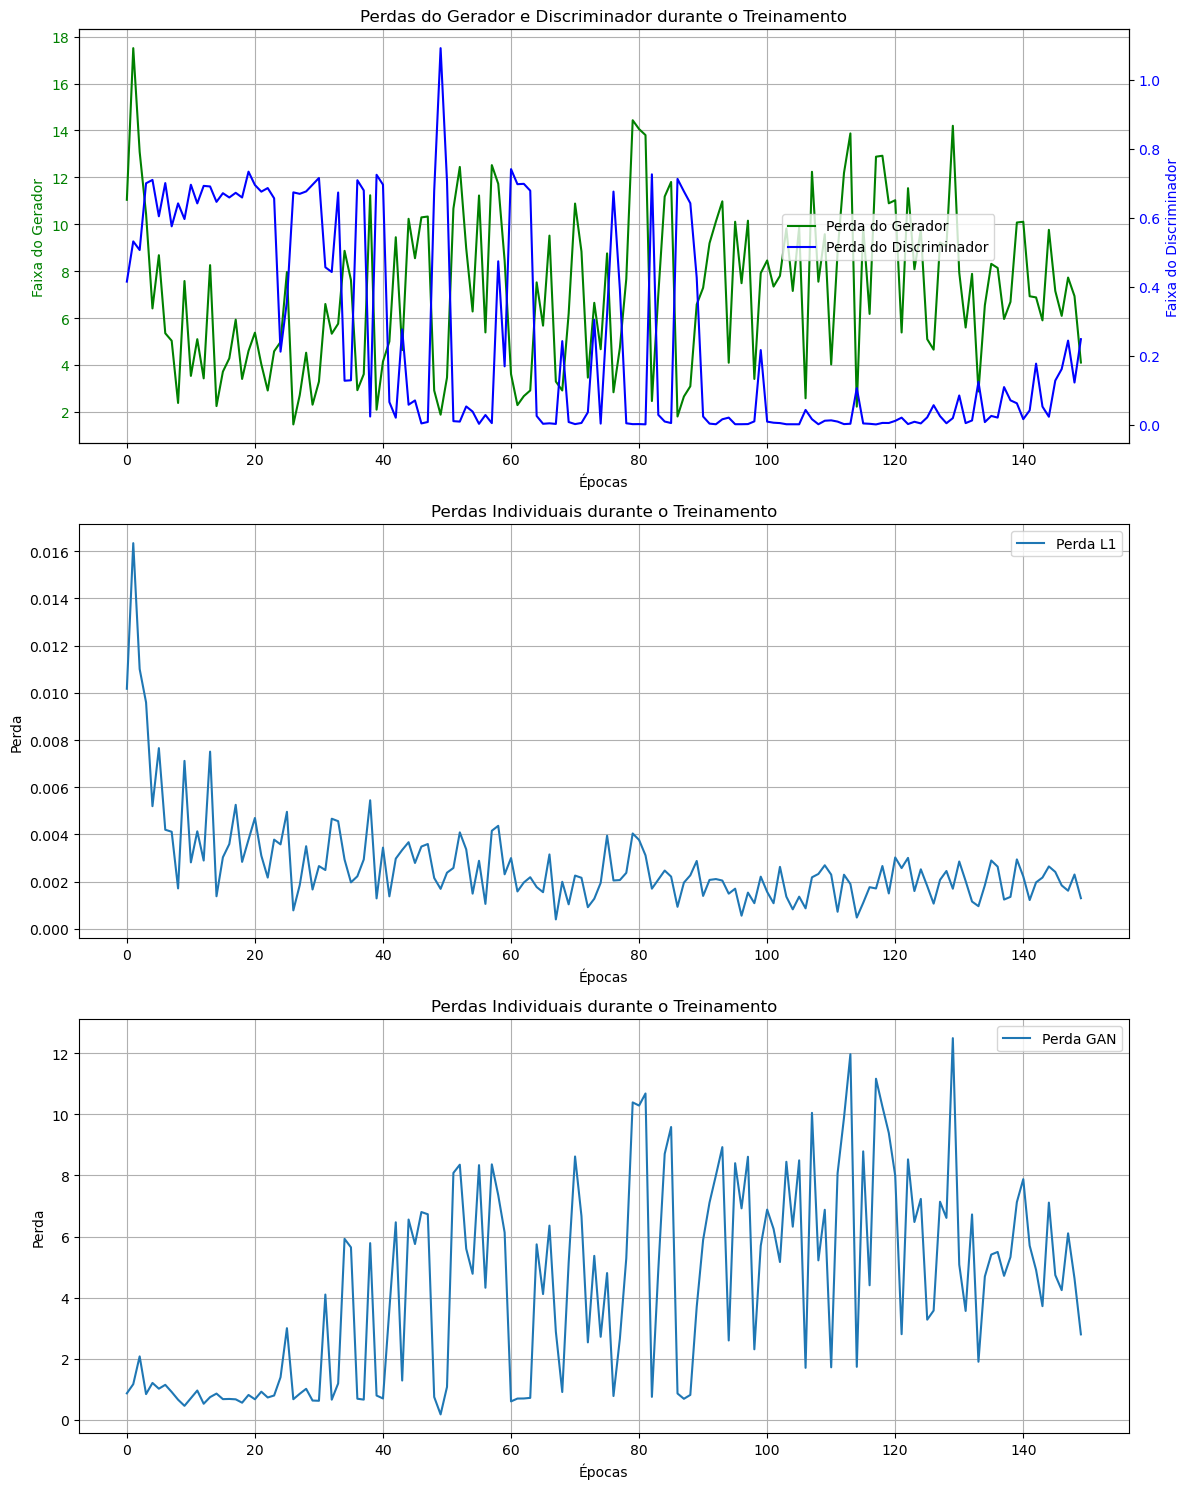

In [21]:
fig, (ax1, ax3, ax4) = plt.subplots(3,1, figsize=(12, 15))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

ax4.plot(GAN_losses, label="Perda GAN")
ax4.set_xlabel("Épocas")
ax4.set_ylabel("Perda")
ax4.set_title("Perdas Individuais durante o Treinamento")
ax4.grid()
ax4.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VX_Loss_V5.png')
plt.show()

In [22]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VXcheckpoint_V5.pth')

checkpoint = torch.load('pix2pix_P2VXcheckpoint_V5.pth', weights_only=True)